# Task 1: ideal mass-spring
Sam Greydanus

In [16]:
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-spring'
sys.path.append(EXPERIMENT_DIR)

from nn_models import MLP
from hnn import HNN
from utils import L2_loss

In [18]:
from functools import partial


In [19]:
tensor = torch.zeros((2,3,4))

In [20]:
tensor = torch.zeros((2,4,3))
l, i, j = tensor.shape
result = tensor[:, 0, :]
print(result.size())
for idx in range(1, i):
    result = torch.einsum('ac,bc->abc',result, tensor[:, idx]).view(-1, tensor.size()[2])
    print(result.size())

torch.Size([2, 3])
torch.Size([4, 3])
torch.Size([8, 3])
torch.Size([16, 3])


In [21]:
result.size()

torch.Size([16, 3])

In [22]:

def scaled_hamiltonian_fn(coords, scale):
    q, p = np.split(coords,2)
    H =  ((1/scale)**2)*q**2 + ((scale)**2)*p**2 
    return H



In [23]:
def scaled_dynamics_fn(t, coords, scale):
    dcoords = autograd.grad(partial(scaled_hamiltonian_fn, scale=scale))(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

In [24]:
#partial(scaled_hamiltonian_fn, scale=?)
#partial()

In [25]:
np.random.rand(2)*2-1

array([-0.14775752,  0.66472708])

In [26]:

def get_trajectory(t_span=[0,3], scale=1, timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0]))+1)
    
    # get initial state
    if y0 is None:
        y0 = scale * np.array([1.,0])
    #    y0 = np.random.rand(2)*2-1
    #if radius is None:
    #    radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    #y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=partial(scaled_dynamics_fn, scale=scale), t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [scaled_dynamics_fn(None, y, scale) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

In [27]:
get_trajectory()

(array([ 0.94091829,  1.04557071,  0.98462708,  0.77046049,  0.4981604 ,
         0.47929978,  0.43009334,  0.09246324, -0.03029362, -0.29295069,
        -0.60936365, -0.6560494 , -0.67008053, -1.09391365, -0.91700504,
        -1.10859882, -0.93744986, -0.89536537, -0.91395216, -0.80793347,
        -0.73427883, -0.62481802, -0.13752253, -0.19865897,  0.24427909,
         0.19771259,  0.52103595,  0.52091194,  0.82790466,  0.85295984,
         0.92891738]),
 array([ 0.06100232, -0.24558367, -0.53223352, -0.48851208, -0.83194607,
        -0.78981919, -0.83473942, -1.02299898, -0.88133794, -0.92566876,
        -0.97888305, -0.66835289, -0.78962961, -0.55317074, -0.35561907,
        -0.08059709,  0.16991808,  0.3608207 ,  0.46489529,  0.58383076,
         0.57420378,  0.74016075,  1.12826684,  0.81008267,  0.91771428,
         1.07338357,  0.90442448,  0.86556742,  0.68554801,  0.61155909,
         0.30895711]),
 array([[ 0.        , -0.39733906, -0.77883735, -1.12928528, -1.43471202,
    

In [31]:
def get_equivariant_dataset(seed=42, train_samples = 25, test_samples=25, **kwargs):
    
    # train set is normal
    # test  set is scaled 
    
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    train_xs, train_dxs = [], []
    for s in range(train_samples):
        x, y, dx, dy, t = get_trajectory(scale=1 , **kwargs)
        train_xs.append( np.stack( [x, y]).T )
        train_dxs.append( np.stack( [dx, dy]).T )
        
    data['train_x'] = np.concatenate(train_xs)
    data['train_dx'] = np.concatenate(train_dxs).squeeze()

    test_xs, test_dxs = [], []
    for s in range(test_samples):
        C = np.random.uniform(0.1, 3)
        x, y, dx, dy, t = get_trajectory(scale=C, **kwargs)
        test_xs.append( np.stack( [x, y]).T )
        test_dxs.append( np.stack( [dx, dy]).T )
        
    data['test_x'] = np.concatenate(test_xs)
    data['test_dx'] = np.concatenate(test_dxs).squeeze()



    return data

In [32]:
data = get_equivariant_dataset()

In [33]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

In [34]:
def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20, scale=1):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    print(scale)
    dydt = [scaled_dynamics_fn(None, y, scale=scale) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [44]:
fig_dir = '.'

1


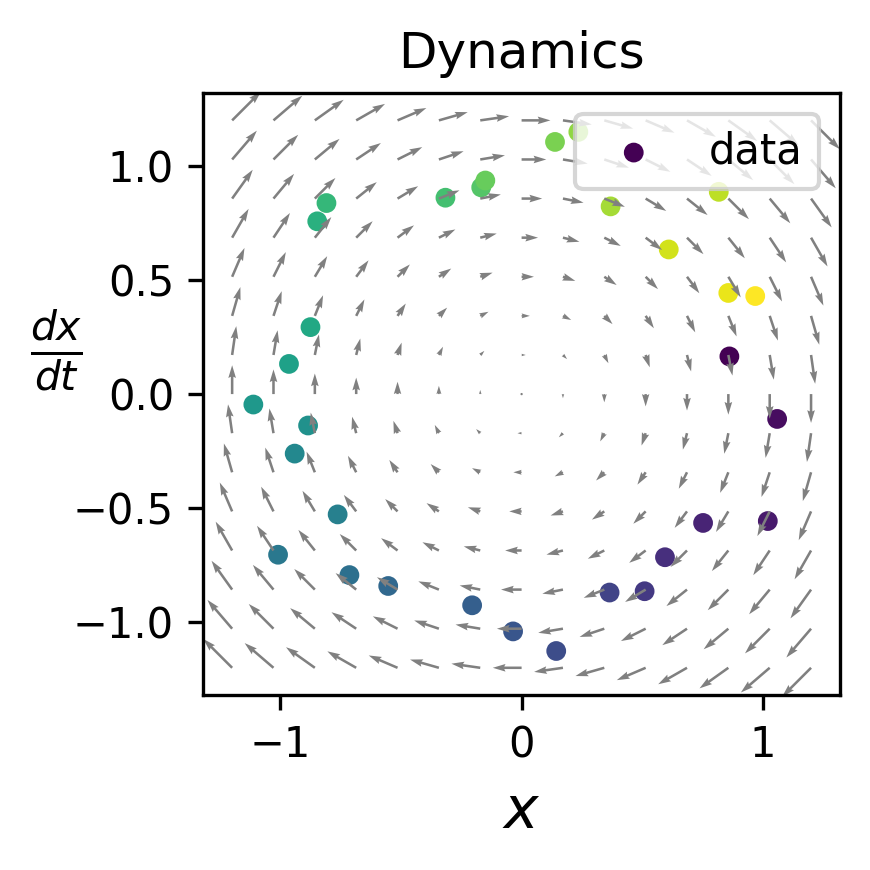

In [45]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
field = get_field(gridsize=15, scale=1)
#data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(scale=1, radius=0.7, y0=np.array([1,0]))
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
fig.savefig(fig_dir + '/spring-task-1.png')

2


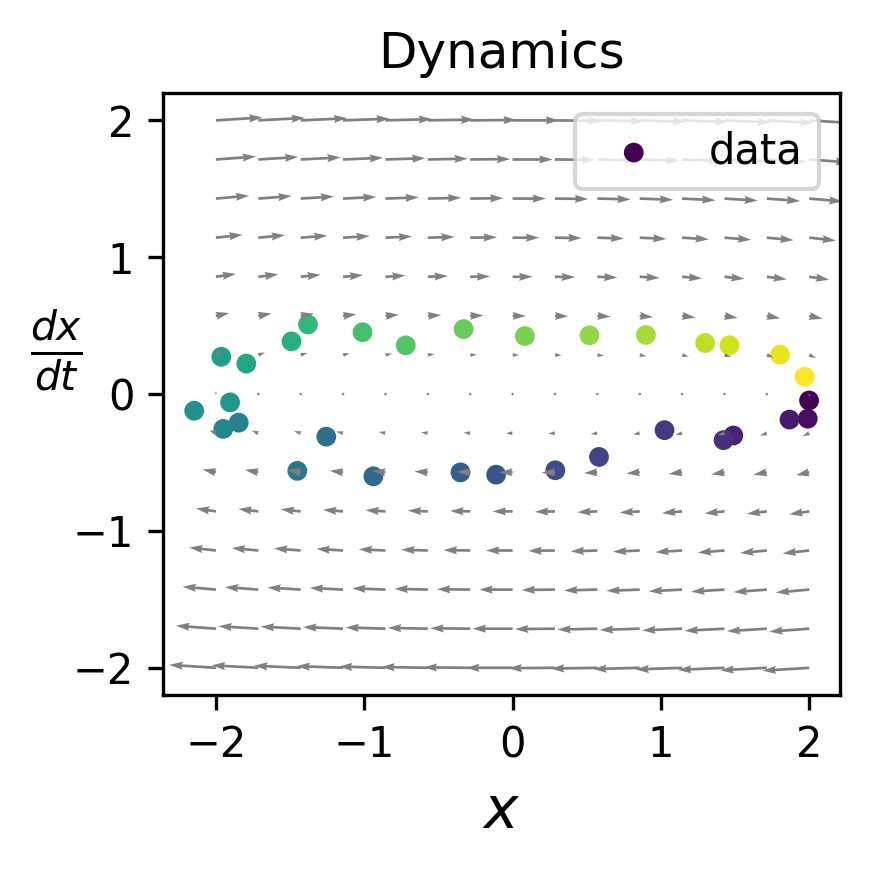

In [46]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
scale = 2
field = get_field(xmin=-2, xmax=2, ymin=-2, ymax=2, gridsize=15, scale=scale)
#data = get_dataset(scale=scale)

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(scale=scale,  y0=scale*np.array([1,0]))
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
#plt.xlim([-1.2,1.2])
#plt.ylim([-1.2,1.2])

plt.tight_layout() ; plt.show()
fig.savefig(fig_dir + '/spring-task-2.png')

In [ ]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
scale = 1
field = get_field(xmin=-3, xmax=3, ymin=-3, ymax=3, gridsize=15, scale=scale)
#data = get_dataset(scale=scale)

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(scale=scale, radius=0.7, y0=np.array([1,0]))
x *= 2
y /= 2
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

3


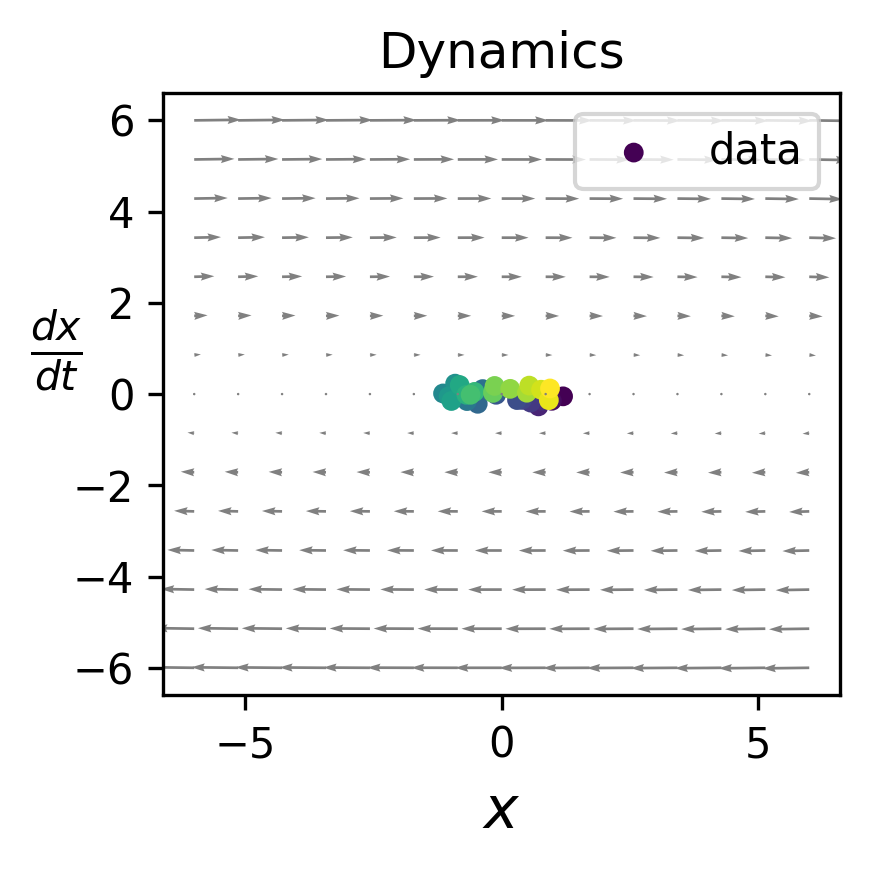

In [20]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
scale = 3
field = get_field(xmin=-6, xmax=6, ymin=-6, ymax=6, gridsize=15, scale=scale)
#data = get_dataset(scale=scale)

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(scale=scale, radius=0.7, y0=np.array([1,0]))
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

In [21]:
# set random seed
torch.manual_seed(0)
np.random.seed(0)

In [22]:
from generate_basis_matrices import generate_basis_matrices

In [23]:
generate_basis_matrices(2,5,3).size()[0]

105

In [30]:
generate_basis_matrices(2,31,1)

KeyboardInterrupt: 

In [25]:
layer_tensor_order = [1,3,5,3,3,3,3,1]

In [26]:
basis_matrices_list = []
parameter_list = []
for layer_in, layer_out in zip(layer_tensor_order[:-1], layer_tensor_order[1:]):
    basis_matrix = generate_basis_matrices(2, layer_in, layer_out)
    basis_matrices_list.append(basis_matrix)
    parameter_list.append(torch.empty(basis_matrix.size()[0]))
    torch.nn.init.normal_(parameter_list[-1])

In [27]:
x = torch.tensor( data['train_x'], requires_grad=True, dtype=torch.float32)


In [28]:
x.size()

torch.Size([775, 2])

In [27]:
#x = torch.tensor( data['train_x'], requires_grad=True, dtype=torch.float32)
scaled_matrix_list = []
for parameter, basis_matrix in zip(parameter_list, basis_matrices_list):
    scaled_matrix = torch.einsum('n, nij->ij', parameter, basis_matrix) 
    scaled_matrix_list.append(scaled_matrix)
    #print(torch.einsum('n, nij->ij', parameter, basis_matrix).size())
    #print(basis_matrix.requires_grad)
    #print(parameter.requires_grad)
    #print(x.size())
    #x = torch.einsum('n, nij, bj->bi', parameter, basis_matrix, x)
    #x = self.nonlinearity(x)

In [28]:
mprod = torch.eye(2)
for m in scaled_matrix_list:
    mprod = m @ mprod

In [29]:
mprod

tensor([[14407.9268,     0.0000],
        [    0.0000, 14407.9268]])

In [30]:
from utils import choose_nonlinearity

#Predict Poisson Bracket 
class equivariantPNN(torch.nn.Module):
    def __init__(self, input_dim, layer_tensor_orders, field_type='solenoidal',assume_canonical_coords=True, nonlinearity='tanh'):
        super(equivariantHNN, self).__init__()

        self.input_dim = input_dim
        self.layer_tensor_order = layer_tensor_orders
        
        self.basis_matrices_list = []
        self.parameter_list = torch.nn.ParameterList()
        self.last_scale = torch.nn.Parameter(torch.rand(1))
        for layer_in, layer_out in zip(self.layer_tensor_order[:-1], self.layer_tensor_order[1:]):
            basis_matrix = generate_basis_matrices(self.input_dim, layer_in, layer_out)
            self.basis_matrices_list.append(basis_matrix)
            self.parameter_list.append(torch.nn.Parameter(torch.empty(basis_matrix.size()[0])))
            torch.nn.init.normal_(self.parameter_list[-1],mean=0.0, std=4)
            #torch.nn.init.sparse_(self.parameter_list[-1], sparsity=0.2)
        self.nonlinearity = choose_nonlinearity(nonlinearity) 
        #self.differentiable_model = differentiable_model
        #self.assume_canonical_coords = assume_canonical_coords
        #self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        #self.field_type = field_type
  
    def forward(self, x):

        for parameter, basis_matrix in zip(self.parameter_list, self.basis_matrices_list):
            #x = torch.einsum('n, nij->ij', parameter, basis_matrix) @ x 
            #x = self.nonlinearity(x)
            x = torch.einsum('n, nij, bj->bi', parameter, basis_matrix, x)
            x = torch.nn.functional.relu(x)
            #parameter = self.nonlinearity(parameter)

        # Final scaling, don't forget. 
        x = x*self.last_scale
        return x


    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        return self.forward(x)

In [31]:
from collections import defaultdict

# Initialize a nested defaultdict
#data = defaultdict(lambda: defaultdict(dict))
#data[1][2][3] = 'w'

In [32]:
tensor = torch.zeros(700,2,3,4)
_,_,i,_ = tensor.size()
result = tensor[:,:, 0, :]
print(result.size())
for idx in range(1, i):
    result = torch.einsum('pac,pbc->pabc',result, tensor[:, :,idx,:]).view(tensor.size()[0],-1, tensor.size()[-1])
    print(result.size())

torch.Size([700, 2, 4])
torch.Size([700, 4, 4])
torch.Size([700, 8, 4])


In [33]:
generate_basis_matrices(0,3,1)

tensor([], size=(3, 0, 0))

In [82]:
basis_matrices = defaultdict(lambda: defaultdict(dict))
basis_matrices[2][2][4] = generate_basis_matrices(2,2,4)
basis_matrices[2][4][4] = generate_basis_matrices(2,4,4)
basis_matrices[2][4][0] = generate_basis_matrices(2,4,0)

basis_matrices[16][3][1] = generate_basis_matrices(16,3,1)
basis_matrices[16][1][1] = generate_basis_matrices(16,1,1)
basis_matrices[4][1][1] = generate_basis_matrices(4,1,1)
basis_matrices[1][3][1] = torch.ones(1,1,1)
torch.autograd.set_detect_anomaly(True)

In [83]:
from utils import choose_nonlinearity
from collections import defaultdict


#Predict Hamiltonian
class equivariantHNN_v2(torch.nn.Module):
    def __init__(self, input_dim, basis_matrices, field_type='solenoidal',assume_canonical_coords=True, nonlinearity='tanh'):
        super(equivariantHNN_v2, self).__init__()

        self.input_dim = input_dim
        #layer tensor orders
        self.layer_num_units = [1,3,3,1]
        self.layer_tensor_orders = [[2],[4,4,4],[4,4,4],[0]]
        self.basis_matrices = basis_matrices
        
        #self.layer_tensor_order = layer_tensor_orders
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.basis_matrices_list = []
        self.parameter_list = torch.nn.ParameterList()
        self.parameter_list_reduce = torch.nn.ParameterList()
        self.last_scale = torch.nn.Parameter(torch.rand(1))
        for i, (layer_in, layer_out) in enumerate(zip(self.layer_num_units[:-1], self.layer_num_units[1:])):
            #basis_matrix = generate_basis_matrices(self.input_dim, layer_in, layer_out)
            #self.basis_matrices_list.append(basis_matrix)
            print('tensororder')
            print(self.layer_tensor_orders[i][0], self.layer_tensor_orders[i+1][0])
            self.parameter_list.append(torch.nn.Parameter(torch.empty(basis_matrices[self.input_dim][self.layer_tensor_orders[i][0]][self.layer_tensor_orders[i+1][0]].size()[0],layer_in,layer_out)))
            print(2**self.layer_tensor_orders[i+1][0], layer_in, 1)
            self.parameter_list_reduce.append(torch.nn.Parameter(torch.empty(basis_matrices[2**self.layer_tensor_orders[i+1][0]][layer_in][1].size()[0],layer_out)))
            torch.nn.init.orthogonal_(self.parameter_list[-1])
            torch.nn.init.orthogonal_(self.parameter_list_reduce[-1])
            #torch.nn.init.normal_(self.parameter_list[-1],mean=0.0, std=1)
            #torch.nn.init.sparse_(self.parameter_list[-1], sparsity=0.2)
        self.nonlinearity = choose_nonlinearity(nonlinearity) 
        #self.differentiable_model = differentiable_model
        #self.assume_canonical_coords = assume_canonical_coords
        #self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        #self.field_type = field_type
  
    def forward(self, x):
        x = torch.einsum('ni,nj->nij', x, x).reshape(-1, 4, 1)
        x = torch.nn.functional.normalize(x, dim=1,eps=1e-8)
        #print(x[0])
        for i, (layer_in, layer_out) in enumerate(zip(self.layer_num_units[:-1], self.layer_num_units[1:])):
            y = torch.einsum('pij, plk, bki-> blij', self.parameter_list[i], self.basis_matrices[self.input_dim][self.layer_tensor_orders[i][0]][self.layer_tensor_orders[i+1][0]], x)
            print(f"y_layer{i}")
            print(y.isnan().any())
            result = y[:,:, 0, :]
            
            #result = torch.nn.functional.normalize(result, dim=1,eps=1e-8)
            #print(result[:2])
            for idx in range(1, layer_in):
                result = torch.einsum('pac,pbc->pabc',result, y[:, :,idx,:]).view(y.size()[0],-1, layer_out)
                #result = torch.nn.functional.normalize(result, dim=1,eps=1e-8)
                print(f"res_layer{i}")
                print(result.isnan().any())
                #print(result[:2])
            
            x = torch.einsum('qj, qts, bsj-> btj', self.parameter_list_reduce[i], self.basis_matrices[2**self.layer_tensor_orders[i+1][0]][layer_in][1], result)
            print(f"x_layer{i}")
            print(x.isnan().any())

        
        x = x.view(-1, 1)
        x = x*self.last_scale
        return x
    
    def permutation_tensor(self,n):
        M = None
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])

        return M

    def time_derivative(self, x, t=None, separate_fields=False):

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F2 = self.forward(x) # traditional forward pass

        solenoidal_field = torch.zeros_like(x)


        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0]# gradients for solenoidal field
        print(f"gradient")
        print("max ", torch.max(dF2))
        print("min ", torch.min(dF2))
        print(dF2.isnan().any())
        solenoidal_field = dF2 @ self.M.t()

        return solenoidal_field


In [84]:
x = torch.tensor( data['train_x'], requires_grad=True, dtype=torch.float32)
test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt = torch.Tensor(data['train_dx'])
test_dxdt = torch.Tensor(data['test_dx'])

# x \otimes x
#x = torch.einsum('ni,nj->nij', x, x).reshape(-1, 4)
#test_x = torch.einsum('ni,nj->nij', test_x, test_x).reshape(-1, 4)

In [85]:
equivariant_model = equivariantHNN_v2(2, basis_matrices)
optim = torch.optim.Adam(equivariant_model.parameters(), 1e-4)

tensororder
2 4
16 1 1
tensororder
4 4
16 3 1
tensororder
4 0
1 3 1


In [86]:
#equivariant_model = equivariantHNN(2, [2,4,4,4,4,4,0])
#optim = torch.optim.Adam(equivariant_model.parameters(), 1e-3)

In [87]:
# vanilla train loop
stats = {'train_loss': [], 'test_loss': []}
for step in range(4000+1):

    # train step
    print("train")
    dxdt_hat = equivariant_model.time_derivative(x)
    #loss_func = torch.nn.L1Loss()
    #loss = loss_func(dxdt, dxdt_hat)
    loss = L2_loss(dxdt, dxdt_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()
    print(f"Step{step}train, looping to check if there are any nan params")

    for param in equivariant_model.parameter_list:
        print(param.isnan().any())
    print("test")
    # run test data
    test_dxdt_hat = equivariant_model.time_derivative(test_x)
    test_loss = L2_loss(test_dxdt, test_dxdt_hat)

    print(f"Step{step}test, looping to check if there are any nan params")
    for param in equivariant_model.parameter_list:
        print(param.isnan().any())
    
    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
    if step % 1 == 0:
        print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))
        #print(f"{equivariant_model.parameter_list[1]}")
        #print(f"{torch.sum(equivariant_model.forward(x))}")
        #print(f"{equivariant_model.forward(x).size()}")
        #print(f"{equivariant_model.time_derivative(x)[:10]}")
        #print(f"{x}")



train
y_layer0
tensor(False)
x_layer0
tensor(False)
y_layer1
tensor(False)
res_layer1
tensor(False)
res_layer1
tensor(False)
x_layer1
tensor(False)
y_layer2
tensor(False)
res_layer2
tensor(False)
res_layer2
tensor(False)
x_layer2
tensor(False)
gradient
max  tensor(3.2975e-33, grad_fn=<MaxBackward1>)
min  tensor(-1.3064e-33, grad_fn=<MinBackward1>)
tensor(False)
Step0train, looping to check if there are any nan params
tensor(False)
tensor(False)
tensor(False)
test
y_layer0
tensor(False)
x_layer0
tensor(False)
y_layer1
tensor(False)
res_layer1
tensor(False)
res_layer1
tensor(False)
x_layer1
tensor(False)
y_layer2
tensor(False)
res_layer2
tensor(False)
res_layer2
tensor(False)
x_layer2
tensor(False)
gradient
max  tensor(1.2776e-33, grad_fn=<MaxBackward1>)
min  tensor(-1.5894e-33, grad_fn=<MinBackward1>)
tensor(False)
Step0test, looping to check if there are any nan params
tensor(False)
tensor(False)
tensor(False)
step 0, train_loss 8.9747e-01, test_loss 2.4146e+01
train
y_layer0
tensor(Fa

KeyboardInterrupt: 

In [ ]:
from utils import choose_nonlinearity

#Predict Hamiltonian
class equivariantHNN(torch.nn.Module):
    def __init__(self, input_dim, layer_tensor_orders, field_type='solenoidal',assume_canonical_coords=True, nonlinearity='tanh'):
        super(equivariantHNN, self).__init__()

        self.input_dim = input_dim
        self.layer_tensor_order = layer_tensor_orders
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.basis_matrices_list = []
        self.parameter_list = torch.nn.ParameterList()
        self.last_scale = torch.nn.Parameter(torch.rand(1))
        for layer_in, layer_out in zip(self.layer_tensor_order[:-1], self.layer_tensor_order[1:]):
            basis_matrix = generate_basis_matrices(self.input_dim, layer_in, layer_out)
            self.basis_matrices_list.append(basis_matrix)
            self.parameter_list.append(torch.nn.Parameter(torch.empty(basis_matrix.size()[0])))
            torch.nn.init.normal_(self.parameter_list[-1],mean=0.0, std=1)
            #torch.nn.init.sparse_(self.parameter_list[-1], sparsity=0.2)
        self.nonlinearity = choose_nonlinearity(nonlinearity) 
        #self.differentiable_model = differentiable_model
        #self.assume_canonical_coords = assume_canonical_coords
        #self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        #self.field_type = field_type
  
    def forward(self, x):
        x = torch.einsum('ni,nj->nij', x, x).reshape(-1, 4)
        
        for parameter, basis_matrix in zip(self.parameter_list, self.basis_matrices_list):
            #x = torch.einsum('n, nij->ij', parameter, basis_matrix) @ x 
            #x = self.nonlinearity(x)
            #print(x.size())
            #print(parameter.size())
            #print(basis_matrix.size())
            x = torch.einsum('n, nij, bj->bi', parameter, basis_matrix, x)
            #x = torch.nn.functional.relu(x)
            #x = torch.nn.functional.tanh(x)
            #parameter = self.nonlinearity(parameter)

        # Final scaling, don't forget. 
        #print(x)
        x = x*self.last_scale
        return x
    
    def permutation_tensor(self,n):
        M = None
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])

        return M

    def time_derivative(self, x, t=None, separate_fields=False):

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F2 = self.forward(x) # traditional forward pass

        solenoidal_field = torch.zeros_like(x)


        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
        solenoidal_field = dF2 @ self.M.t()

        return solenoidal_field


In [42]:
equivariant_model.last_scale

Parameter containing:
tensor([0.6610], requires_grad=True)

In [18]:
output_dim = 2
nn_model = MLP(2, 200, 2, 'tanh')

In [19]:

model = HNN(2, differentiable_model=nn_model,
          field_type='solenoidal', baseline='baseline')
optim = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4)

In [20]:
data = get_equivariant_dataset(seed=0)

In [24]:
x = torch.tensor( data['train_x'], requires_grad=True, dtype=torch.float32)
test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt = torch.Tensor(data['train_dx'])
test_dxdt = torch.Tensor(data['test_dx'])


In [33]:
# vanilla train loop
stats = {'train_loss': [], 'test_loss': []}
for step in range(2000+1):

    # train step
    dxdt_hat = model.time_derivative(x)
    loss = L2_loss(dxdt, dxdt_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()
    
    # run test data
    test_dxdt_hat = model.time_derivative(test_x)
    test_loss = L2_loss(test_dxdt, test_dxdt_hat)
    
    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
    if step % 50 == 0:
      print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))


NameError: name 'model' is not defined

In [ ]:


train_dxdt_hat = model.time_derivative(x)
train_dist = (dxdt - train_dxdt_hat)**2
test_dxdt_hat = model.time_derivative(test_x)
test_dist = (test_dxdt - test_dxdt_hat)**2
print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
.format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
        test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))



## Set some notebook constants

In [31]:
!python3 experiment-spring/train_transform.py --transform --verbose

Training HNN model:
step 0, train_loss 2.2308e+00, test_loss 2.0380e+00
step 200, train_loss 6.6519e-01, test_loss 9.5605e-01
step 400, train_loss 5.7027e-01, test_loss 9.8993e-01
step 600, train_loss 5.4633e-01, test_loss 1.0136e+00
step 800, train_loss 5.1499e-01, test_loss 1.0436e+00
step 1000, train_loss 4.9825e-01, test_loss 1.0649e+00
step 1200, train_loss 4.8726e-01, test_loss 1.0850e+00
step 1400, train_loss 4.6812e-01, test_loss 1.1109e+00
step 1600, train_loss 4.5113e-01, test_loss 1.1494e+00
step 1800, train_loss 4.3547e-01, test_loss 1.2185e+00
step 2000, train_loss 4.0590e-01, test_loss 1.4165e+00
Final train loss 4.0618e-01 +/- 7.1322e-02
Final test loss 1.4165e+00 +/- 1.3618e-01


In [7]:
!python3 experiment-spring/train.py --verbose

Training HNN model:
step 0, train_loss 8.0734e-01, test_loss 7.7651e-01
step 200, train_loss 3.7101e-02, test_loss 3.5972e-02
step 400, train_loss 3.7043e-02, test_loss 3.5980e-02
step 600, train_loss 3.7044e-02, test_loss 3.5961e-02
step 800, train_loss 3.7005e-02, test_loss 3.5973e-02
step 1000, train_loss 3.6990e-02, test_loss 3.5968e-02
step 1200, train_loss 3.6981e-02, test_loss 3.5952e-02
step 1400, train_loss 3.8560e-02, test_loss 3.8201e-02
step 1600, train_loss 3.6956e-02, test_loss 3.5937e-02
step 1800, train_loss 3.6942e-02, test_loss 3.5970e-02
step 2000, train_loss 3.6927e-02, test_loss 3.5921e-02
Final train loss 3.6928e-02 +/- 1.9127e-03
Final test loss 3.5921e-02 +/- 1.8310e-03


In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Construct models

In [6]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/spring{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [7]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [8]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [11]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset()
base_field = get_vector_field(base_model, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1., 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Plot results

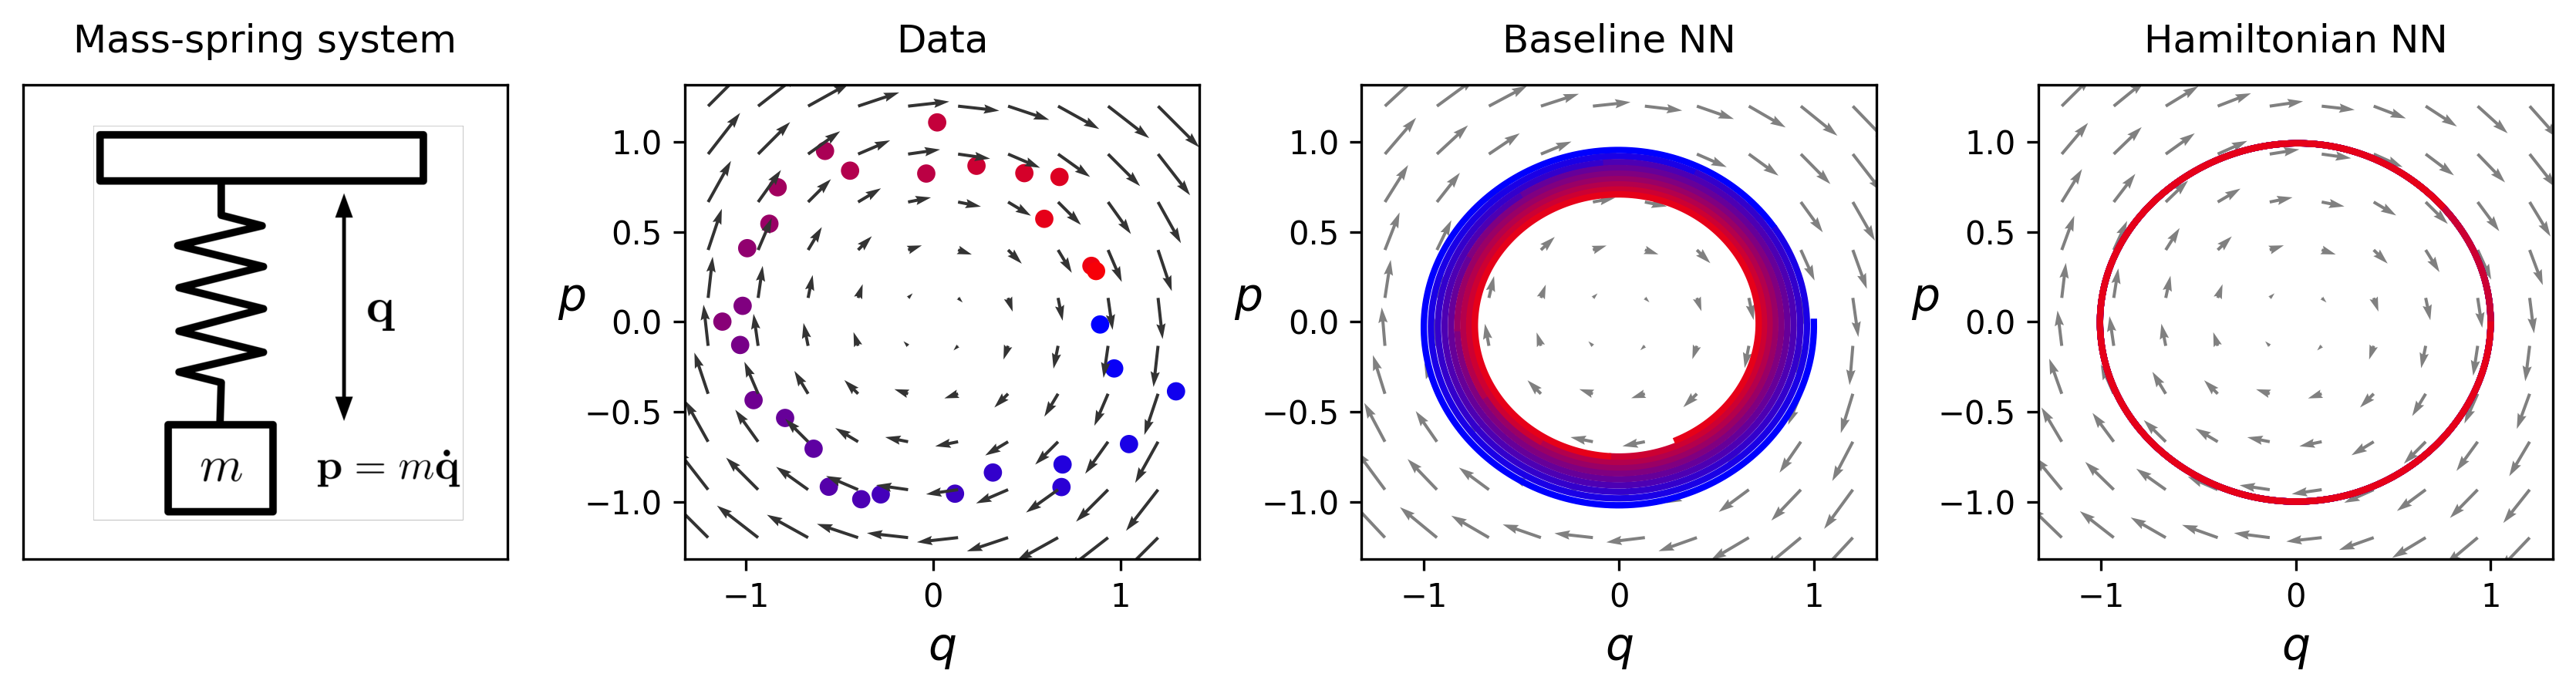

In [12]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(1, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/mass-spring.png')
plt.imshow(schema)
plt.title("Mass-spring system", pad=10)

# plot dynamics
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=1, y0=np.array([1,0]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [13]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    
    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, base_x, hnn_x

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

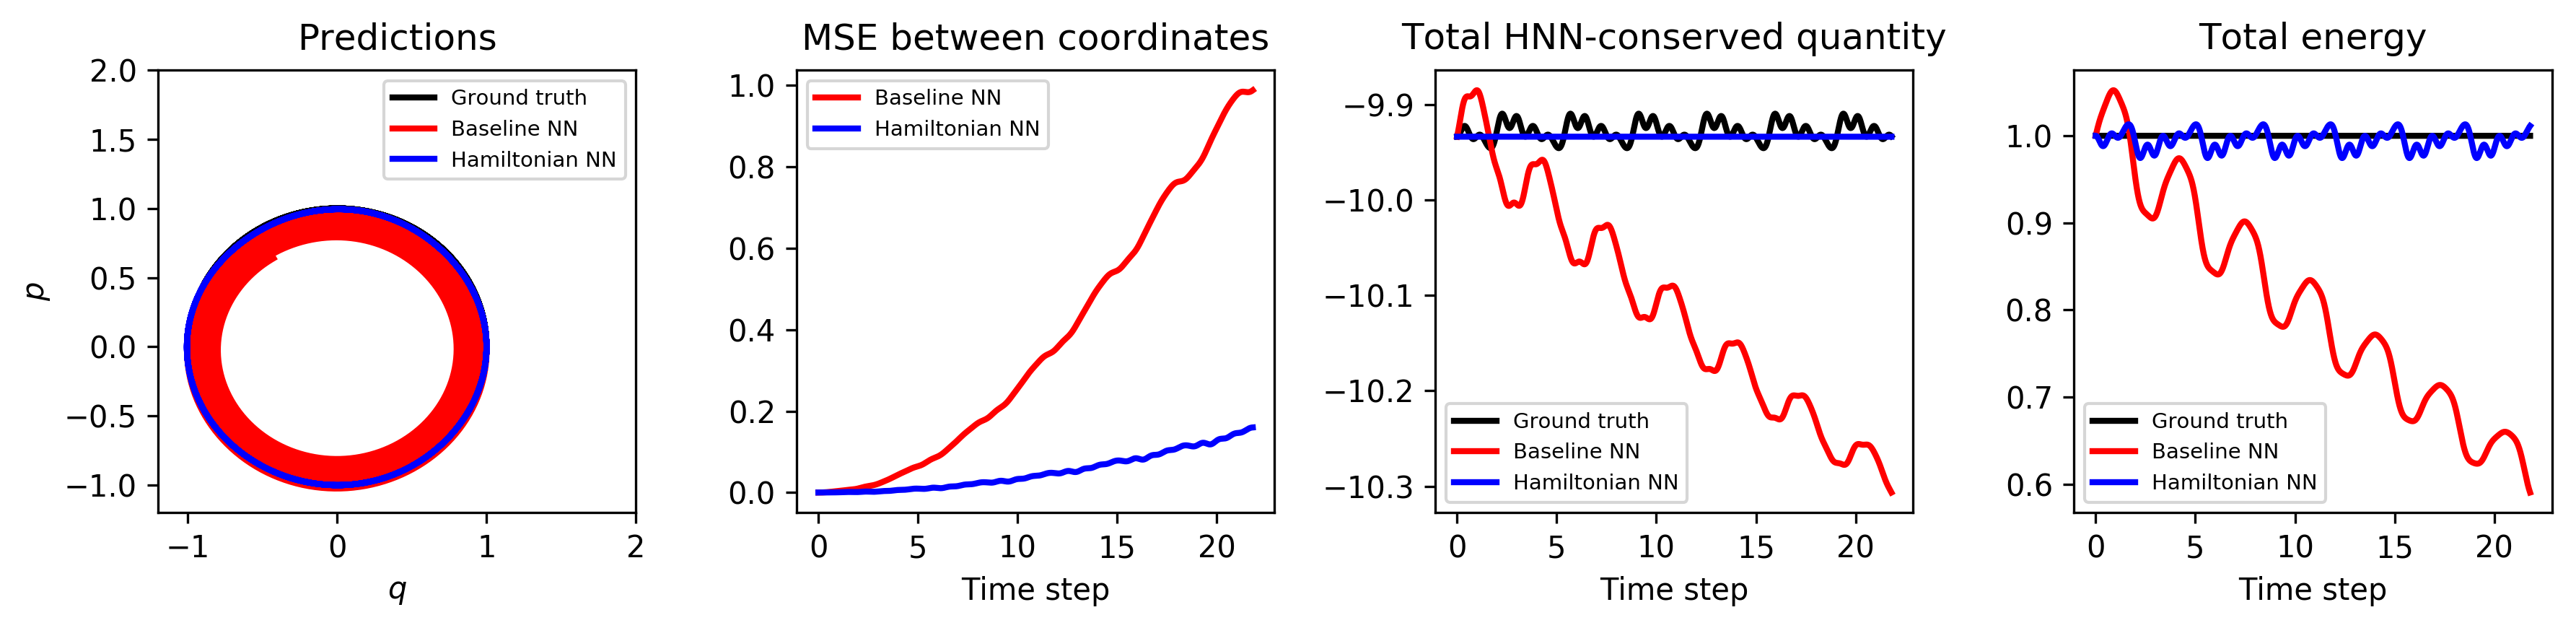

In [19]:
x0 = np.asarray([1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-1.2,2) ; plt.ylim(-1.2,2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

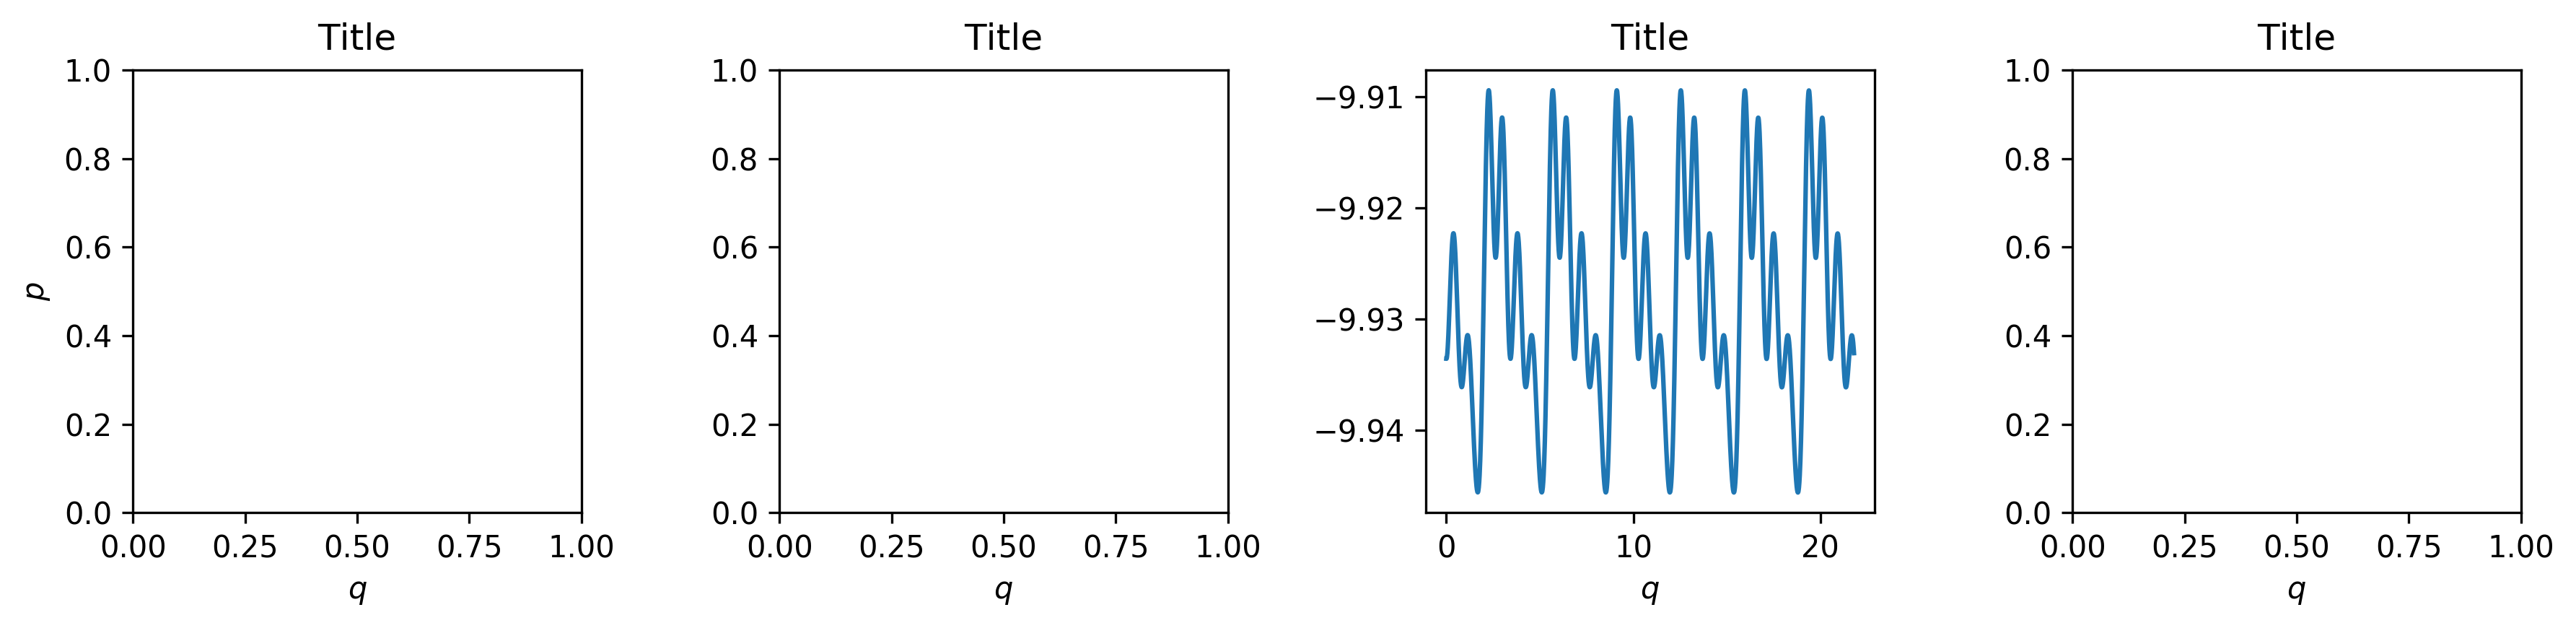

In [20]:

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')

plt.subplot(1,4,2)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$')

plt.subplot(1,4,3)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$')
plt.plot(t_eval, true_hq)

plt.subplot(1,4,4)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$')


plt.tight_layout() ; plt.show()
fig.savefig('{}/blank{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [29]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [30]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )


Baseline NN energy MSE: 1.7077e-01 +/- 2.06e-02
Hamiltonian NN energy MSE: 3.8416e-04 +/- 6.53e-05
